<a href="https://colab.research.google.com/github/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/supplementary/what_is_to_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Modules**

In [ ]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import math
from numpy import linalg
import sympy

from sympy import symbols
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
init_vprinting(pretty_print=True)

import plotly.graph_objects as go

In [ ]:
class MugasRigidBodyFunctions:

    def __init__(self):
        pass


    def hat_matrix(self, x):
        """
        Computes the skew-symmetric matrix (hat matrix) corresponding to a 3 by 1 matrix.

        The hat matrix is a representation of the cross product operation as a matrix.
        It is commonly used in rigid body dynamics, robotics, and control theory to
        transform a vector into its corresponding cross-product operation.

        Args:
            x (numpy.ndarray): A 3-element numpy array representing a 3 by 1 matrix.

        Returns:
            numpy.ndarray: A 3x3 skew-symmetric matrix corresponding to the input 3 by 1 matrix.

        Example:
            Input: x = [1, 2, 3]
            Output:
            [[  0., -3.,  2.],
            [  3.,  0., -1.],
            [ -2.,  1.,  0.]]
        """
        return np.array([
            [0., -x[2], x[1]],
            [x[2],  0., -x[0]],
            [-x[1], x[0],  0.]
        ])


    def q_from_axis_angles(self, theta, unit_axis):
        """
        Computes a quaternion from a given rotation angle and unit axis.

        A quaternion is a compact representation of rotations in 3D space.
        It is composed of a scalar part and a 3 by 1 matrix part, where the scalar represents the
        rotation magnitude, and the 3 by 1 matrix encodes the rotation axis.

        Args:
            theta (float): The rotation angle in radians.
            unit_axis (list or numpy.ndarray): A 3-element unit 3 by 1 matrix representing the axis of rotation.

        Returns:
            numpy.ndarray: A 4-element array representing the quaternion [q0, q1, q2, q3],
                          where q0 is the scalar part, and [q1, q2, q3] is the 3 by 1 matrix part.

        Formula:
            Quaternion (q) = [cos(theta / 2), sin(theta / 2) * unit_axis]

        Example:
            Input: theta = π/2, unit_axis = [0, 0, 1] (z-axis)
            Output: [0.7071, 0.0, 0.0, 0.7071] (represents a 90-degree rotation about the z-axis)

        Notes:
            - Ensure the input `unit_axis` is normalized to avoid incorrect results.
            - Commonly used in 3D transformations and rigid body dynamics.

        """
        # Compute the scalar part of the quaternion (cosine of half the rotation angle)
        scalar_part = np.cos(theta / 2)

        # Compute the vector part of the quaternion (sine of half the rotation angle times the unit axis)
        three_by_one_matrix_part = np.sin(theta / 2) * np.array(unit_axis)

        # Combine scalar and vector parts into a single quaternion
        return np.concatenate(([scalar_part], three_by_one_matrix_part))


    def r_from_quaternions(self, q):
        """
        Computes a rotation matrix from a given quaternion.

        The rotation matrix is a \(3 \times 3\) orthogonal matrix that represents a rotation
        in 3D space. This method utilizes a quaternion to derive the corresponding rotation matrix.

        Args:
            q (numpy.ndarray): A 4-element numpy array representing the quaternion [q0, q1, q2, q3],
                              where q0 is the scalar part, and [q1, q2, q3] forms a \(3 \times 1\) matrix.

        Returns:
            numpy.ndarray: A \(3 \times 3\) rotation matrix corresponding to the input quaternion.

        Formula:
            Rotation Matrix (R) = I + 2 * q0 * hat(w) + 2 * hat(w) @ hat(w)
            - \(I\): Identity matrix (\(3 \times 3\)).
            - \(q0\): Scalar part of the quaternion.
            - \(w\): \(3 \times 1\) matrix (vector part of the quaternion).
            - \(hat(w)\): Skew-symmetric (hat) matrix of \(w\).

        Example:
            Input: q = [0.7071, 0.7071, 0, 0] (90-degree rotation about x-axis)
            Output:
            [[ 1.   0.   0.  ]
            [ 0.   0.  -1.  ]
            [ 0.   1.   0.  ]]

        Notes:
            - Input quaternion \(q\) should be normalized to ensure a valid rotation matrix.
            - The method converts the vector part of the quaternion into a \(3 \times 1\) matrix internally.
        """
        # Extract the scalar part of the quaternion (q0)
        q0 = q[0]

        # Extract the direction part and reshape it into a 3x1 matrix
        w = q[1:] #.reshape((3, 1))

        # Compute the rotation matrix using the quaternion formula
        return (
            np.identity(3) +
            2 * q0 * self.hat_matrix(w) +
            2 * self.hat_matrix(w) @ self.hat_matrix(w)
        )


    def rotation_matrix_2_euler_angles(self, R):
        """
        Converts a \(3 \times 3\) rotation matrix into its corresponding Euler angles.

        Euler angles provide a representation of rotations using three consecutive rotations about
        specified axes. This method extracts the angles (φ, θ, ψ) from the rotation matrix \(R\).

        Args:
            R (numpy.ndarray): A \(3 \times 3\) rotation matrix representing the rotation in 3D space.

        Returns:
            tuple: A tuple of three angles (φ, θ, ψ) in radians:
                - φ (phi): Rotation about the z-axis.
                - θ (theta): Rotation about the y-axis.
                - ψ (psi): Rotation about the x-axis.

        Formula:
            Depending on the structure of the rotation matrix \(R\):
            - Handle standard cases when \(R[2, 2] > -1\) and \(R[2, 2] < 1\).
            - Handle gimbal lock cases when \(R[2, 2] = ±1\).

        Example:
            Input:
            R = [[ 0.866, -0.5,  0. ],
                [ 0.5,    0.866, 0. ],
                [ 0. ,    0. ,   1. ]]
            Output: (φ=0.5236, θ=0.0, ψ=0.0) (30° rotation about z-axis)

        Notes:
            - Euler angles are dependent on the chosen axis order (assumes ZYX order here).
            - Handles edge cases like gimbal lock (singularities in rotation representation).
        """
        # Check the third row, third column element to determine the rotation scenario
        if R[2, 2] < 1:  # General case: not gimbal lock
            if R[2, 2] > -1:  # Unique solution
                phi = np.pi - math.atan2(R[0, 2], R[1, 2])  # Rotation about z-axis
                theta = math.acos(R[2, 2])  # Rotation about y-axis
                psi = np.pi - math.atan2(R[2, 0], -R[2, 1])  # Rotation about x-axis
                return phi, theta, psi
            # Gimbal lock: theta = π
            phi = -math.atan2(R[0, 1], -R[0, 0])  # Rotation about z-axis
            return phi, np.pi, 0
        # Gimbal lock: theta = 0
        phi = math.atan2(R[0, 1], R[0, 0])  # Rotation about z-axis
        return phi, 0, 0

    def re3_equals_gamma(self, gamma):
        """
        Computes a rotation matrix \( R \) such that \( R \cdot e_3 = \gamma \),
        where \( e_3 \) is the unit axis along the z-axis.

        This method constructs a rotation matrix that aligns the z-axis (\( e_3 \))
        with a given 3D vector (\( \gamma \)). It uses the axis-angle representation
        to calculate the required rotation.

        Args:
            gamma (numpy.ndarray): A 3-element numpy array (or \(3 \times 1\) matrix)
                                  representing the target axis to align \( e_3 \) with.
                                  \( \gamma \) should be normalized.

        Returns:
            numpy.ndarray: A \(3 \times 3\) rotation matrix \( R \) such that \( R \cdot e_3 = \gamma \).

        Formula:
            1. Compute the angle \( \theta = \arccos(\gamma[2]) \).
            2. Determine the rotation axis \( n \):
              \( n = [-\gamma[1]/\sin(\theta), \gamma[0]/\sin(\theta), 0] \).
            3. Construct the quaternion using \( \theta \) and \( n \).
            4. Convert the quaternion to a rotation matrix \( R \).

        Example:
            Input:
            gamma = [0, 0, 1]  # Already aligned with e_3
            Output:
            [[1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, 1.0]]  # Identity matrix

            Input:
            gamma = [1/√2, 0, 1/√2]  # 45-degree tilt in the xz-plane
            Output:
            [[ 0.7071, 0.0,  0.7071],
            [ 0.0,    1.0,  0.0   ],
            [-0.7071, 0.0,  0.7071]]

        Notes:
            - \( \gamma \) must be normalized before passing to the function.
            - If \( \sin(\theta) \) is close to zero, the method handles the edge case
              where \( \gamma \) is aligned with \( e_3 \) directly.
        """
        # Compute the rotation angle (theta) between e3 and gamma
        theta = math.acos(gamma[2])

        # Handle edge case where gamma is already aligned with e3
        if np.isclose(np.sin(theta), 0):
            return np.identity(3)  # No rotation needed

        # Compute the rotation axis (n) as a 3x1 matrix
        n = np.array([[-gamma[1] / np.sin(theta)],
                      [gamma[0] / np.sin(theta)],
                      [0]])

        # Construct the quaternion and compute the rotation matrix
        return self.r_from_quaternions(self.q_from_axis_angles(theta, n))


    def rotate_and_translate(self, object_vertices, R, o):
        """
        Applies a rotation and translation to a set of object vertices.

        This method transforms an object's vertices by first applying a rotation
        using the provided rotation matrix \( R \), and then translating the result
        by the translation  \( o \).

        Args:
            object_vertices (numpy.ndarray): A \(3 \times N\) matrix where each column represents
                                            the coordinates of a vertex in the object.
            R (numpy.ndarray): A \(3 \times 3\) rotation matrix representing the orientation.
            o (numpy.ndarray): A \(3 \times 1\) matrix (or list/array of 3 elements)
                              representing the translation.

        Returns:
            numpy.ndarray: A \(3 \times N\) matrix where each column represents the transformed
                          coordinates of the vertices after applying the rotation and translation.

        Formula:
            Transformed Vertices = Translation + Rotation @ Original Vertices
            \[
            \text{Transformed Vertices} = o + R \cdot \text{object\_vertices}
            \]

        Example:
            Input:
            object_vertices = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]  # 3 vertices
            R = [[0, -1, 0], [1, 0, 0], [0, 0, 1]]  # 90-degree rotation about z-axis
            o = [1, 1, 0]  # Translation]

            Output:
            [[1, 1, 1], [0, 2, 1], [0, 0, 1]]  # Transformed vertices

        Notes:
            - The object vertices should be provided as a \(3 \times N\) matrix.
            - The translation  \( o \) should be a \(3 \times 1\) matrix or convertible to one.
            - Ensures seamless transformation of 3D objects in simulations and graphics.
        """
        # Reshape the translation into a 3x1 matrix if not already in that form
        o = np.array([[o[0], o[1], o[2]]]).T

        # Apply the rotation and translation to the object vertices
        return o + R @ object_vertices

    def add_orth_norm_frame(self, fig, o, R, axis_range, axis_color):
        """
        Adds an orthonormal frame to a 3D Plotly figure, representing the axes of a rotated frame.

        This method visualizes a rotated orthonormal frame in a 3D plot. The frame is defined
        by its origin and a rotation matrix, and it is represented by three arrows indicating
        the rotated \( x \)-axis, \( y \)-axis, and \( z \)-axis.

        Args:
            fig (plotly.graph_objects.Figure): The 3D figure to which the frame will be added.
            o (numpy.ndarray): A \(3 \times 1\) matrix (or list/array of 3 elements) representing
                              the origin of the frame in 3D space.
            R (numpy.ndarray): A \(3 \times 3\) rotation matrix defining the orientation of the frame.
            axis_range (list of tuples): Specifies the range for each axis in the format
                                        [(x_min, x_max), (y_min, y_max), (z_min, z_max)].
            axis_color (str): Color for the axis lines in the frame (e.g., "red", "blue", "green").

        Returns:
            plotly.graph_objects.Figure: The input figure with the added orthonormal frame.

        Example:
            Input:
            fig = go.Figure()  # Empty 3D figure
            o = [0, 0, 0]  # Origin at (0, 0, 0)
            R = [[0, -1, 0], [1, 0, 0], [0, 0, 1]]  # 90-degree rotation about z-axis
            axis_range = [(-1, 1), (-1, 1), (-1, 1)]
            axis_color = "blue"

            Output:
            A 3D figure with the rotated frame visualized.

        Notes:
            - Each axis of the frame is scaled based on the rotation matrix \( R \).
            - The figure layout is updated to match the specified axis range and ensure aspect ratio consistency.
        """
        # Define the standard basis vectors for the x, y, and z axes
        e = [np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])]

        # Apply the rotation matrix R to each e-frame axis to compute the rotated b-frame axes
        b = [R @ ei for ei in e]

        # Add each axis as a line starting at origin `o` and extending in the rotated direction
        for bi in b:
            fig.add_trace(go.Scatter3d(
                x=[o[0], o[0] + bi[0]],  # Line along the rotated axis
                y=[o[1], o[1] + bi[1]],
                z=[o[2], o[2] + bi[2]],
                hoverinfo='x+y+z',  # Tooltip displays the 3D coordinates
                mode='lines',  # Display as lines
                line=dict(width=8, color=axis_color)  # Line styling
            ))

        # Update the layout to fix the axis ranges and maintain aspect ratio
        fig.update_layout(
            showlegend=False,  # Hide legend
            scene=dict(
                xaxis=dict(range=axis_range[0], autorange=False),
                yaxis=dict(range=axis_range[1], autorange=False),
                zaxis=dict(range=axis_range[2], autorange=False),
                aspectratio=dict(x=1, y=1, z=1)  # Keep the aspect ratio uniform
            )
        )
        return fig

    def add_orth_norm_frame(self, fig, o, R, axis_range, axis_color):
        """
        Adds an orthonormal frame to a 3D Plotly figure, representing the axes of a rotated frame.

        This method visualizes a rotated orthonormal frame in a 3D plot. The frame is defined
        by its origin and a rotation matrix, and it is represented by three arrows indicating
        the rotated \( x \)-axis, \( y \)-axis, and \( z \)-axis.

        Args:
            fig (plotly.graph_objects.Figure): The 3D figure to which the frame will be added.
            o (numpy.ndarray): A \(3 \times 1\) matrix (or list/array of 3 elements) representing
                              the origin of the frame in 3D space.
            R (numpy.ndarray): A \(3 \times 3\) rotation matrix defining the orientation of the frame.
            axis_range (list of tuples): Specifies the range for each axis in the format
                                        [(x_min, x_max), (y_min, y_max), (z_min, z_max)].
            axis_color (str): Color for the axis lines in the frame (e.g., "red", "blue", "green").

        Returns:
            plotly.graph_objects.Figure: The input figure with the added orthonormal frame.

        Example:
            Input:
            fig = go.Figure()  # Empty 3D figure
            o = [0, 0, 0]  # Origin at (0, 0, 0)
            R = [[0, -1, 0], [1, 0, 0], [0, 0, 1]]  # 90-degree rotation about z-axis
            axis_range = [(-1, 1), (-1, 1), (-1, 1)]
            axis_color = "blue"

            Output:
            A 3D figure with the rotated frame visualized.

        Notes:
            - Each axis of the frame is scaled based on the rotation matrix \( R \).
            - The figure layout is updated to match the specified axis range and ensure aspect ratio consistency.
        """
        # Define the e-frame axis for the x, y, and z axes
        e = [np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])]

        # Apply the rotation matrix R to each e-frame axis to compute the rotated b-frame axes
        b = [R @ ei for ei in e]

        # Add each axis as a line starting at origin `o` and extending in the rotated direction
        for bi in b:
            fig.add_trace(go.Scatter3d(
                x=[o[0], o[0] + bi[0]],  # Line along the rotated axis
                y=[o[1], o[1] + bi[1]],
                z=[o[2], o[2] + bi[2]],
                hoverinfo='x+y+z',  # Tooltip displays the 3D coordinates
                mode='lines',  # Display as lines
                line=dict(width=8, color=axis_color)  # Line styling
            ))

        # Update the layout to fix the axis ranges and maintain aspect ratio
        fig.update_layout(
            showlegend=False,  # Hide legend
            scene=dict(
                xaxis=dict(range=axis_range[0], autorange=False),
                yaxis=dict(range=axis_range[1], autorange=False),
                zaxis=dict(range=axis_range[2], autorange=False),
                aspectratio=dict(x=1, y=1, z=1)  # Keep the aspect ratio uniform
            )
        )
        return fig

    def animate_particle_motion(self, xx, axis_range, fig_title):
        """
        Creates a 3D animated visualization of a particle's motion over time.

        This method visualizes the trajectory of a particle in 3D space, showing both
        the particle's current position as a marker and the entire path it follows as a line.

        Args:
            xx (list of tuples): A list of 3D coordinates representing the particle's position
                                at each time step, formatted as [(x1, y1, z1), (x2, y2, z2), ...].
            axis_range (list of tuples): Specifies the range for each axis in the format
                                        [(x_min, x_max), (y_min, y_max), (z_min, z_max)].
            fig_title (str): Title for the animated 3D plot.

        Returns:
            plotly.graph_objects.Figure: A Plotly figure object containing the animated 3D scatter plot.

        Example:
            Input:
            xx = [(0, 0, 0), (1, 0, 0), (2, 1, 0), (3, 2, 1)]  # Particle's path
            axis_range = [(-5, 5), (-5, 5), (-5, 5)]  # Axis limits
            fig_title = "Particle Motion Animation"

            Output:
            A Plotly animated 3D scatter plot showing the particle's motion over time.

        Notes:
            - The particle's current position is shown as a red marker.
            - The complete trajectory is shown as a blue line.
            - The animation can be controlled using play/pause buttons in the Plotly interface.

        """
        # Unpack the particle's trajectory into separate x, y, z coordinates
        x_vals, y_vals, z_vals = zip(*xx)

        # Define the initial position of the particle as a red marker
        trace_particle = go.Scatter3d(
            x=[x_vals[0]], y=[y_vals[0]], z=[z_vals[0]],  # Start with the first position
            mode="markers",  # Show as a marker
            marker=dict(color="red", size=10)  # Red marker with size 10
        )

        # Define the complete trajectory as a blue line
        trace_path = go.Scatter3d(
            x=x_vals, y=y_vals, z=z_vals,  # All trajectory points
            mode="lines",  # Show as a line
            line=dict(color="blue", width=2),  # Blue line with width 2
            name='Path'
        )

        # Define the layout of the plot
        layout = go.Layout(
            title_text=fig_title,  # Title of the figure
            hovermode="closest",  # Tooltip shows closest data point
            updatemenus=[dict(
                type="buttons",
                buttons=[dict(
                    label="Play",  # Play button for the animation
                    method="animate",
                    args=[None]
                )]
            )],
            scene=dict(  # 3D scene settings
                xaxis=dict(range=axis_range[0], autorange=False),  # Fixed x-axis range
                yaxis=dict(range=axis_range[1], autorange=False),  # Fixed y-axis range
                zaxis=dict(range=axis_range[2], autorange=False),  # Fixed z-axis range
                aspectratio=dict(x=1, y=1, z=1)  # Uniform aspect ratio
            )
        )

        # Create animation frames for each point in the trajectory
        frames = [go.Frame(
            data=[go.Scatter3d(
                x=[point[0]], y=[point[1]], z=[point[2]],  # Current position of the particle
                mode="markers",  # Show as a marker
                marker=dict(color="red", size=10),  # Red marker with size 10
                name='Particle'
            )]) for point in xx]

        # Create the Plotly figure with initial data, layout, and frames
        fig = go.Figure(data=[trace_particle, trace_path], layout=layout, frames=frames)

        # Display the figure
        fig.show()

        # Return the figure object
        return fig

    def rigid_body_system(self, parameters, t, X):
        """
        Models the dynamics of a rigid body system.

        This method computes the time derivatives and other intermediate quantities
        for a rigid body's state, based on the provided parameters and external forces/torques.

        Args:
            parameters (dict): A dictionary containing parameters for the rigid body system:
                - 'CM' (numpy.ndarray): Center of mass position as a \(3 \times 1\) matrix.
                - 'M' (float): Mass of the rigid body.
            t (float): Current time (useful for time-dependent forces/torques).
            X (list): State of the system, containing:
                - \( X[0][0] \) (numpy.ndarray): Rotation matrix \( R \) (\(3 \times 3\)).
                - \( X[1] \) (numpy.ndarray): Spatial angular velocity \( \omega \) (\(3 \times 1\)).
                - \( X[2] \) (numpy.ndarray): Linear momentum r \( p \) (\(3 \times 1\)).

        Returns:
            list: A list of quantities for the rigid body dynamics:
                - \( \thetaomega \) (float): Magnitude of spatial angular velocity \( \omega \).
                - \( \nomega \) (numpy.ndarray): Normalized spatial angular velocity axis(\(3 \times 1\)).
                - \( \doto \) (numpy.ndarray): Time derivative of the position (\(3 \times 1\)).
                - \( dp \) (numpy.ndarray): Time derivative of linear momentum (\(3 \times 1\)).
                - \( dspi \) (numpy.ndarray): Time derivative of spatial angular momentum (\(3 \times 1\)).
                - \( dXc \) (numpy.ndarray): Time derivative of other external dynamics (\(3 \times 1\)).

        Formula:
            The equations are modeled as:
            - \( \dot{o} = \frac{p}{M} \)
            - \( \dot{p} = f_e + f_a \)
            - \( \dot{\text{spi}} = \tau_e + \tau_a \)
            - \( \omega = \text{angular velocity} \)

        Example:
            Input:
            parameters = {'CM': [0, 0, 0], 'M': 10}
            t = 0
            X = [[[np.eye(3)], [1, 0, 0], [0, 1, 0]]]

            Output:
            - \( \thetaomega \): 1.0
            - \( \nomega \): [1, 0, 0]
            - \( \doto \): [0, 0.1, 0.1]
            - \( dp \): ...
            - ...

        Notes:
            - Requires user-defined `externalForceModel` and `actuator` functions to provide
              external and actuator forces/torques.
            - Spatial angular velocity \( \omega \) is normalized if its magnitude exceeds a small threshold.

        """
        # Extract parameters
        barX, M = parameters['CM'], parameters['M']

        # Extract state variables
        R = X[0][0]  # Rotation matrix
        omega = X[1]  # Spatial angular velocity
        p = X[2]  # Linear momentum

        # Compute external and actuator forces and torques
        taue, fe = externalForceModel(self, parameters, X)  # External forces and torques
        taua, fa = actuator(self, parameters, t, X, taue, fe)  # Actuator forces and torques

        # Compute time derivatives of position, momentum, and spin
        doto = p / M  # Time derivative of position
        dp = fe + fa  # Time derivative of linear momentum
        dspi = taue + taua  # Time derivative of spin

        # External dynamics (can be expanded with a controller model)
        dXc = np.array([0., 0., 0.])

        # Compute angular velocity properties
        if np.linalg.norm(omega) >= 0.0001:  # Avoid division by zero
            nomega = omega / np.linalg.norm(omega)  # Normalized angular velocity
            thetaomega = np.linalg.norm(omega)  # Magnitude of angular velocity
        else:  # Handle case of negligible angular velocity
            nomega = np.array([0, 0, 0])
            thetaomega = 0

        # Return computed quantities
        return [thetaomega, nomega, doto, dp, dspi, dXc]


    def animate_2D_scatter_plot(self, x, YY, xlabel, ylabel, title):
        """
        Creates an animated 2D scatter plot using Plotly.

        This method visualizes a series of 2D data points as an animation, where the y-values
        evolve over time for a fixed set of x-values. It is useful for illustrating dynamic
        changes in data over time.

        Args:
            x (numpy.ndarray): A 1D array representing the x-axis values.
            YY (numpy.ndarray): A 2D array where each row represents the y-values at a specific
                                time step, and columns correspond to the x-values.
            xlabel (str): Label for the x-axis.
            ylabel (str): Label for the y-axis.
            title (str): Title for the animated plot.

        Returns:
            plotly.graph_objects.Figure: A Plotly figure object containing the animated scatter plot.

        Example:
            Input:
            x = np.linspace(0, 10, 100)  # x-values
            YY = np.array([np.sin(x + t) for t in np.linspace(0, 2 * np.pi, 50)])  # y-values evolve over time
            xlabel = "X-axis"
            ylabel = "Y-axis"
            title = "Animated 2D Scatter Plot"

            Output:
            A Plotly animated scatter plot showing the evolution of the sine wave over time.

        Notes:
            - The animation buttons are included by default in the plot layout.
            - The range of the y-axis is automatically determined based on the data in `YY`.

        """
        # Define the layout of the plot
        layout = go.Layout(
            xaxis={'title': xlabel},  # Label for the x-axis
            yaxis={'title': ylabel, 'range': [1.1 * YY.min(), 1.1 * YY.max()]},  # Label and range for the y-axis
            title={'text': title, 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},  # Title styling
            scene=dict(aspectratio=dict(x=1, y=1)),  # Maintain aspect ratio
            hovermode="closest",  # Display closest data point information
            updatemenus=[dict(
                type="buttons",
                buttons=[
                    dict(
                        label="Play",  # Animation play button
                        method="animate",
                        args=[None]
                    )
                ]
            )]
        )

        # Create frames for each time step in YY
        frames = [go.Frame(data=[go.Scatter(x=x, y=y)]) for y in YY]

        # Initialize the figure with the first frame's data and the layout
        fig = go.Figure(data=[go.Scatter(x=x, y=YY[0, :])], layout=layout, frames=frames)

        # Return the figure object (can be displayed using fig.show())
        return fig


    def simulate_dy_system(self, dynamic_system_model, t_max, dt, x0, sys_para, fig_title, x_label, y_label):
        """
        Simulates the dynamics of a system using a numerical solver and visualizes the results.

        This method solves a system of differential equations defined by a user-provided
        dynamic system model, using initial conditions and system parameters. The solution
        is plotted over time for visualization.

        Args:
            dynamic_system_model (function): The function defining the system's dynamics.
                                            It should return \( \frac{dx}{dt} \) given
                                            the current state, time, and parameters.
            t_max (float): The total simulation time.
            dt (float): The time step for the simulation.
            x0 (numpy.ndarray): Initial state of the system (\( n \times 1 \) matrix or array).
            sys_para (any): Parameters for the dynamic system model, passed as an argument to the function.
            fig_title (str): Title for the generated plot.
            x_label (str): Label for the x-axis of the plot (typically time).
            y_label (str): Label for the y-axis of the plot (state variables).

        Returns:
            tuple: A tuple containing:
                - t (numpy.ndarray): The array of time points.
                - sol (numpy.ndarray): The solution matrix where each row corresponds to
                                      the state vector at a specific time.
                - fig (plotly.graph_objects.Figure): The Plotly figure object showing the simulation results.

        Example:
            Input:
            dynamic_system_model = LinearSystemModel  # A predefined dynamic model
            t_max = 10  # Simulate for 10 seconds
            dt = 0.1  # Time step of 0.1 seconds
            x0 = [1, 0]  # Initial state
            sys_para = [[0, 1], [-1, -2]]  # System matrix A
            fig_title = "System Dynamics"
            x_label = "Time (s)"
            y_label = "State Variables"

            Output:
            - Time array \( t \)
            - Solution matrix \( sol \)
            - Plotly figure showing the state variables over time

        Notes:
            - The `dynamic_system_model` must accept parameters in the form
              `(state_vector, time, system_parameters)`.
            - Uses `scipy.integrate.odeint` for numerical integration.
            - Visualization is done using Plotly, with each state variable plotted as a line.

        """
        # Generate time points for the simulation
        t = np.linspace(0, t_max, int(t_max / dt + 1))

        # Solve the system of differential equations
        sol = odeint(dynamic_system_model, x0, t, args=(sys_para,))

        # Create a Plotly figure for visualization
        fig = go.Figure()

        # Add a line plot for each state variable
        for sol_col in sol.T:
            fig.add_trace(go.Scatter(x=t, y=sol_col, mode='lines+markers'))

        # Update the figure layout with titles and axis labels
        fig.update_layout(
            title=fig_title,
            xaxis=dict(title=x_label),
            yaxis=dict(title=y_label)
        )

        # Display the figure
        fig.show()

        # Return the time points, solution matrix, and figure
        return t, sol, fig

    def LinearSystemModel(self, X, t, A):
        """
        Represents a linear dynamic system model.

        This function defines the evolution of a linear system over time using the
        state-space representation. It calculates the time derivative of the state
         \( X \) given the system matrix \( A \).

        Args:
            X (numpy.ndarray): A \( n \times 1 \) matrix (or list/array of \( n \) elements)
                              representing the state of the system.
            t (float): Time variable (not used in the calculation but required for compatibility
                      with ODE solvers).
            A (numpy.ndarray): A \( n \times n \) matrix representing the system matrix that defines
                              the linear dynamics.

        Returns:
            numpy.ndarray: The time derivative of the state \( dX/dt \), computed as \( A \cdot X \).

        Formula:
            The system is modeled as:
            \[
            \frac{dX}{dt} = A \cdot X
            \]

        Example:
            Input:
            X = [1, 2]
            t = 0  # Time (not used in this example)
            A = [[0, 1], [-1, -2]]  # System matrix

            Output:
            [-2, -5]  # Time derivative of the state vector

        Notes:
            - Ensure the dimensions of \( A \) and \( X \) are consistent (\( A \) should be square and
              \( X \) should have the appropriate size).
            - Commonly used in simulations of linear systems such as control systems and electrical circuits.
        """
        # Compute the time derivative of the state vector using the system matrix
        dXdt = A @ X
        return dXdt


    def cube_vertices(self, cube_dimensions):
        l, w, h = cube_dimensions['l'], cube_dimensions['w'], cube_dimensions['h']
        xp, yp, zp = cube_dimensions['xp'], cube_dimensions['yp'], cube_dimensions['zp']

        X = [-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]
        Y = [-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]
        Z = [-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]

        return [X, Y, Z]

    def animated_cube_flat_shading(self, cubeVertices,figTitle):
        fig = go.Figure(
            frames=[go.Frame(data=[
            go.Mesh3d(
                # 8 vertices of a cube
                x=xx[0][0],
                y=xx[0][1],
                z=xx[0][2],
                # i, j and k give the vertices of triangles
                i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
                j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
                k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
                name='y',
                opacity=0.6,
                color='#DC143C',
                flatshading = True)]) for xx in cubeVertices])

        fig.add_trace(go.Mesh3d(
                # 8 vertices of a cube
                x=cubeVertices[0][0][0],
                y=cubeVertices[0][0][1],
                z=cubeVertices[0][0][2],
                # i, j and k give the vertices of triangles
                i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
                j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
                k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
                name='y',
                opacity=0.6,
                color='#DC143C',
                flatshading = True)
            )

        duration=10;
        fig.update_layout(
            title=figTitle,width=600,height=600,
            scene=dict(xaxis=dict(range=[-5., 5.], autorange=False),yaxis=dict(range=[-5., 5.], autorange=False),zaxis=dict(range=[-5., 5.], autorange=False),aspectratio=dict(x=1, y=1, z=1),),
            updatemenus=[dict(type="buttons",
                                buttons=[dict(label="Play",
                                                method="animate",
                                                args=[None, {"frame": {"duration": duration},"mode": "immediate","fromcurrent": True, "transition": {"duration": duration, "easing": "linear"},}]
                                                )])])
        len(fig.frames)
        fig.show()
        return fig


    def eulers_method(self, dt, Tmax, parameters, ICs):
        M, II = parameters['M'], parameters['II']
        invII = np.linalg.inv(II)
        timeSteps = np.arange(0, Tmax+dt, dt)
        R, o, omega, doto, Xc = ICs[0][0], ICs[0][1], ICs[1], ICs[2], ICs[3]
        spi = R @ II @ R.T @ omega
        p = M * doto
        Xout = [ICs]

        for t in timeSteps:
            taue, fe = externalForceModel(self, parameters, X)
            taua, fa = actuator(self, parameters, t, X, taue, fe)

            dspi = taue + taua
            dp = fe + fa

            if np.linalg.norm(omega) >= 0.0001:
                nomega = omega / np.linalg.norm(omega)
                thetaomegat = dt * np.linalg.norm(omega)
                qomegat = np.concatenate(([np.cos(thetaomegat/2)], np.sin(thetaomegat/2) * nomega))
                R = self.r_from_quaternions(qomegat) @ R

            o += dt * doto
            spi += dt * dspi
            p += dt * dp
            doto = p / M
            omega = R @ invII @ R.T @ spi
            X = [[R, o], omega, doto, Xc]
            Xout.append(X)

        return Xout

    def runga_kutta_method(self, dt, Tmax, parameters, ICs):
        M, II = parameters['M'], parameters['II']
        invII = np.linalg.inv(II)
        timeSteps = np.arange(0, Tmax+dt, dt)
        X=ICs;
        Xout=[X];

        for t in timeSteps:
            Y1 = self.rk4_function(0.5*dt, X, t, X, parameters)
            Y2 = self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters)
            Y3 = self.rk4_function(dt, X, t+0.5*dt, Y2, parameters)

            values = [self.rigid_body_system(parameters, t+i*dt, X_j) for i, X_j in enumerate([X, Y1, Y2, Y3])]
            thetas, n_omegas, dotos, dps, dspis, dXcs = zip(*values)

            omegak = (dt/6.0) * sum(t * n for t, n in zip(thetas, n_omegas))
            nomegak = omegak/np.linalg.norm(omegak) if np.linalg.norm(omegak) >= 0.0001 else np.array([0, 0, 0])
            qomegak = np.concatenate(([np.cos(np.linalg.norm(omegak)/2)], np.sin(np.linalg.norm(omegak)/2) * nomegak))
            Rk = self.r_from_quaternions(qomegak) @ X[0][0]

            ok = X[0][1] + dt * np.mean(dotos)
            pk = X[2] + dt * np.mean(dps)
            spik = X[0][0] @ II @ X[0][0].T @ X[1] + dt * np.mean(dspis)
            Xck = X[3] + dt * np.mean(dXcs)

            omegak = Rk @ invII @ Rk.T @ spik
            X = [[Rk, ok], omegak, pk, Xck]
            Xout.append(X)

        return Xout

    def rk4_function(self, dtk, X, tk, Xk, parameters):
        M, II = parameters['M'], parameters['II']
        thetaomega1, nomega1, doto1, dp1, dspi1, dXc1 = self.rigid_body_system(parameters, tk, Xk)
        qomega1 = np.concatenate(([np.cos(dtk*thetaomega1/2)], np.sin(dtk*thetaomega1/2) * nomega1))
        R1 = self.r_from_quaternions(qomega1) @ X[0][0]
        p1 = X[2] + dtk * dp1
        spi1 = X[0][0] @ II @ X[0][0].T @ X[1] + dtk * dspi1
        omega1 = R1 @ np.linalg.inv(II) @ R1.T @ spi1
        X1 = [[R1, X[0][1] + dtk * doto1], omega1, p1, X[3] + dtk * dXc1]
        return X1


    def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
        XX=self.cube_vertices(cubeDimensions);

        #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
        Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);
        ICR=ICs[0][0];
        XX0=ICR @ XX;

        rotatedVertices=[[XX0]]
        for X in Xs:
        #print(X[0])
            R=X[0][0];
            o=X[0][1];
            XXi=self.rotate_and_translate(XX,R,o);
            XX0=XXi;
            rotatedVertices+=[[XX0]];
        return rotatedVertices

mr=MugasRigidBodyFunctions()

In [ ]:
def LinearSystemModel(X, t, A):
    """
    Represents a linear dynamic system model.

    This function defines the evolution of a linear system over time using the
    state-space representation. It calculates the time derivative of the state
    vector \( X \) given the system matrix \( A \).

    Args:
        X (numpy.ndarray): A \( n \times 1 \) matrix (or list/array of \( n \) elements)
                           representing the state vector of the system.
        t (float): Time variable (not used in the calculation but required for compatibility
                   with ODE solvers).
        A (numpy.ndarray): A \( n \times n \) matrix representing the system matrix that defines
                           the linear dynamics.

    Returns:
        numpy.ndarray: The time derivative of the state vector \( dX/dt \), computed as \( A \cdot X \).

    Formula:
        The system is modeled as:
        \[
        \frac{dX}{dt} = A \cdot X
        \]

    Example:
        Input:
        X = [1, 2]
        t = 0  # Time (not used in this example)
        A = [[0, 1], [-1, -2]]  # System matrix

        Output:
        [-2, -5]  # Time derivative of the state vector

    Notes:
        - Ensure the dimensions of \( A \) and \( X \) are consistent (\( A \) should be square and
          \( X \) should have the appropriate size).
        - Commonly used in simulations of linear systems such as control systems and electrical circuits.
    """
    # Compute the time derivative of the state vector using the system matrix
    dXdt = A @ X
    return dXdt

#How can we describe the behavior of this system

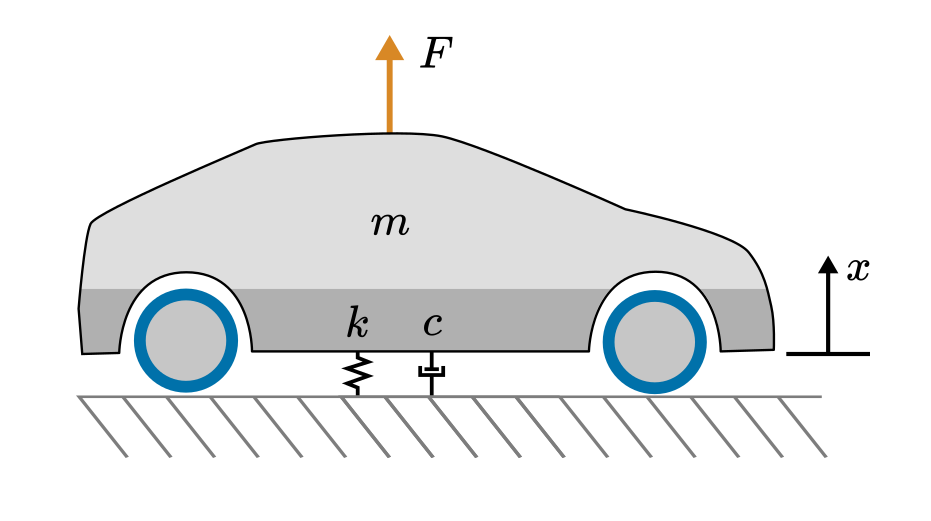

## Lets try this?

### The approximate model of the system

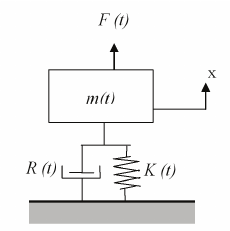

Newtons equations for this approximately modelled system gives us that
\begin{align*}
m\ddot{x}+c\dot{x}+kx=F
\end{align*}

This is a second order linear differential equation.

### What does this differential equation tells us?

The above equations can be reduced to the form

\begin{align*}
\ddot{x}+2\zeta \omega_n\dot{x}+\omega_n^2x=\frac{1}{m}F
\end{align*}
where we have set $\omega_n^2=k/m$ and $2\zeta\omega_n=c/m$.

#### Lets try to find the solutions of this differential equation

The above system can also be written down as a first order matrix ODE
\begin{align*}
\dot{Y}=AY+BF
\end{align*}
where
\begin{align*}
A=\left[\begin{matrix}0 & 1\\- \omega_{n}^{2} & - 2 \omega_{n} \zeta\end{matrix}\right],
\end{align*}
\begin{align*}
B=\left[\begin{matrix}0 \\\frac{1}{m}\end{matrix}\right]
\end{align*}
and
\begin{align*}
Y=\left[\begin{matrix}x \\ \dot{x}\end{matrix}\right]
\end{align*}

####Numerical Solution

In [ ]:
m=1; k=10; c=float(m*2*0.1*sqrt(k/m));
A=np.array([[0,1],[-k/m,-c/m]]);
[t,sol,fig]=mr.simulate_dy_system(LinearSystemModel, 10,0.01, [1,0], A, 'Spring Mass Damper System', 'Time / t', 'x')

#### Analytical Solution

Taking the Laplase transform of the above linear ODE The transfer function representation of this system is
\begin{align*}
X(s)=G(s)U(s)
\end{align*}
where $U(s)=F(s)/m$ and
\begin{align*}
G(s)=\frac{1}{s^{2} + 2 \zeta\omega_{n} s  + \omega_{n}^{2}}
\end{align*}

The roots of the denomunator pynomial
\begin{align*}
f(s)=s^2+2\zeta\omega_n s+\omega_n^2
\end{align*}
is given by

In [ ]:
s, omega_n , zeta = symbols('s omega_n zeta', real=True)
fs = s**2 + (2*zeta*omega_n*s) + (omega_n**2)
solve(fs, s)

#### The parameter dependence of the roots

In [ ]:
import matplotlib.pyplot as plt

# Define parameters
omega_n = 1  # Natural frequency
zeta = np.linspace(0, 2, 500)  # Damping ratio range

# Compute roots
s1 = -omega_n * zeta + omega_n * np.sqrt(zeta**2 - 1 + 0j)  # Root 1
s2 = -omega_n * zeta - omega_n * np.sqrt(zeta**2 - 1 + 0j)  # Root 2

# Separate real and imaginary parts
s1_real, s1_imag = s1.real, s1.imag
s2_real, s2_imag = s2.real, s2.imag

# Plot the roots
plt.figure(figsize=(10, 6))

plt.plot(s1_real, s1_imag, label="Root 1 (Real vs Imag)", color="blue")
plt.plot(s2_real, s2_imag, label="Root 2 (Real vs Imag)", color="red")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.axvline(0, color="black", linestyle="--", linewidth=0.8)

plt.title("Roots of the Polynomial $\omega_{n}^2 + 2 \omega_{n} s \zeta + s^2$")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.legend()
plt.show()


#### The underdamped case: $0\leq\zeta <1$

For this case we see that the the partial fraction expansion of $G(s)$ takes the form
\begin{align*}
G(s)=\frac{1}{s^2+2\zeta\omega_n s+\omega_n^2}=\frac{i\alpha}{s+p}-\frac{i{\alpha}}{s+\bar{p}}
\end{align*}
where
\begin{align*}
\alpha = \frac{1}{2\omega_n\sqrt{1-\zeta^2}}.
\end{align*}

In [ ]:
s, omega_n , zeta = symbols('s omega_n zeta', real=True)
G = 1/(s**2 + (2*zeta*omega_n*s) + (omega_n**2))
G

In [ ]:
Gs = G.subs({zeta:0.9,omega_n:1.1})
Gs

In [ ]:
apart(Gs, full=True).doit()

####The analytical solution

The explicit analytical solution for $0<\zeta < 1$ is:

\begin{align*}
x(t) = e^{-\zeta \omega_n t} \left( x_0 \cos(\omega_d t) + \frac{v_0 + \zeta \omega_n x_0}{\omega_d} \sin(\omega_d t) \right),
\end{align*}

where:

\begin{align*}
\omega_d = \omega_n \sqrt{1 - \zeta^2}.
\end{align*}

#### How is this related to the solutions of the matrix ODE

\begin{align*}
\dot{Y}=AY+BF
\end{align*}
where
\begin{align*}
A=\left[\begin{matrix}0 & 1\\- \omega_{n}^{2} & - 2 \omega_{n} \zeta\end{matrix}\right],
\end{align*}
\begin{align*}
B=\left[\begin{matrix}0 \\\frac{1}{m}\end{matrix}\right]
\end{align*}
and
\begin{align*}
Y=\left[\begin{matrix}x \\ \dot{x}\end{matrix}\right]
\end{align*}

Find the eigenvalues and eigenvectors of

\begin{align*}
A=\left[\begin{matrix}0 & 1\\- \omega_{n}^{2} & - 2 \omega_{n} \zeta\end{matrix}\right]
\end{align*}

In [ ]:
omega_n , zeta = symbols('omega_n zeta', real=True)
E = Matrix([[0,1],[-omega_n**2, -2*zeta*omega_n]])
E

In [ ]:
E.eigenvals()

In [ ]:
E.eigenvects()

In [ ]:
init_printing()
E.eigenvects()

In [ ]:
init_printing(pretty_print=False)
E.eigenvects()

# Lets ask Wolfram:

https://chatgpt.com/g/g-0S5FXLyFN-wolfram

#**What are the challenges of Getting a Higher Education in an AI Driven World**

#WEC

https://chatgpt.com/share/67558833-bb70-800b-9312-11b9ee8c0b6d